In [9]:
%matplotlib inline

In [10]:
!pip install keras-tuner

     |████████████████████████████████| 98 kB 4.1 MB/s 


In [11]:
# keras
import tensorflow
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import initializers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import Dense,Lambda,Activation
from tensorflow.keras.optimizers import Adam,SGD,RMSprop,Adamax
from tensorflow.keras.models import Sequential,Model,load_model,save_model
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Embedding,Input,Dense,Reshape,Flatten,Dropout,Multiply,Concatenate
from keras.utils.vis_utils import plot_model
from tensorflow.keras import regularizers
import tensorflow as tf
import keras_tuner as kt

# sklearn
from sklearn.model_selection import train_test_split

# pytorch
# import torch
# from torch import nn

import requests
import zipfile
import copy

import pandas as pd
import numpy as np
import random
import math

from matplotlib import pyplot as plt

In [4]:
np.random.seed(123)
random.seed(123)

In [5]:
url = 'http://files.grouplens.org/datasets/movielens/ml-1m.zip'
zip_name = 'ml-1m.zip'
data_dir = 'ml-1m/'

r = requests.get(url, allow_redirects=True)
open(zip_name, 'wb').write(r.content)

with zipfile.ZipFile(zip_name,"r") as zip_ref:
    zip_ref.extractall()

In [6]:
ratings_df = pd.read_csv('/content/ml-1m/ratings.dat', header=None, names=['user_id', 'item_id', 'rating', 'timestamp'], delimiter='::')
ratings_df.head()

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,user_id,item_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


we are not intrested in timestamps, so we can remove the column. <br>
also, in order to keep embedding size as small as possible, we need to change the user and item ids.

In [7]:
ratings_df.drop(columns='timestamp', inplace=True)

def user_id_trans(idx):
    return idx-1

item_id_trans_dict =  {k:v for k,v in zip(ratings_df.item_id.unique(),range(ratings_df.item_id.nunique()))}
def item_id_trans(key_value):
    return item_id_trans_dict[key_value]

ratings_df.user_id = ratings_df.user_id.apply(user_id_trans)
ratings_df.item_id = ratings_df.item_id.apply(item_id_trans)

ratings_df.head()

,user_id,item_id,rating
0,0,0,5
1,0,1,3
2,0,2,3
3,0,3,4
4,0,4,5


In [8]:
ml_users_num, ml_items_num = ratings_df.user_id.nunique(), ratings_df.item_id.nunique()
ml_users_num, ml_items_num

(6040, 3706)

splitting the data into train, validation and test:

In [9]:
train, test = train_test_split(ratings_df, test_size=0.1, random_state=42)
train.user_id.nunique(), train.item_id.nunique()

def create_full_mat(df):
    full_mat = np.zeros((ml_users_num, ml_items_num))
    for user, item, rating in zip(df.user_id, df.item_id, df.rating):
        full_mat[user, item] = rating
    return full_mat

full_train_mat = create_full_mat(train)
full_test_mat = create_full_mat(test)

In [10]:
def df_to_mat(df):
    full_mat = np.zeros((df.user_id.max()+1, df.item_id.max()+1))
    for user, item, rating in zip(df.user_id, df.item_id, df.rating):
        full_mat[user, item] = rating
    return full_mat

In [11]:
# train.item_id.unique() not in list(range(ml_items_num))
# list(set(range(ml_items_num)) - set(train.item_id.unique()))

In [12]:
class MF:
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    mc = ModelCheckpoint('best_mf_model.h5', monitor='val_loss', mode='min', save_best_only=True)

    def __init__(self, users_num, items_num, latent_dim=20, optimizer='Adam', loss='mean_squared_error', learning_rate=0.01):
        self.users_num = users_num
        self.items_num = items_num
        self.optimizer = optimizer
        self.loss = loss
        self.learning_rate = learning_rate
        self.latent_dim = latent_dim

        # user_input = Input(shape=(1,), name='user_input', dtype='int32')
        # item_input = Input(shape=(1,), name='item_input', dtype='int32')

        # user_embedding = Embedding(input_dim=users_num, output_dim=latent_dim, name='user_embedding')(user_input)
        # item_embedding = Embedding(input_dim=items_num, output_dim=latent_dim, name='item_embedding')(item_input)

        # user_latent = Flatten()(user_embedding)
        # item_latent = Flatten()(item_embedding)

        # pred = keras.layers.dot([user_latent, item_latent], axes=1, normalize=False)
        # self.model = Model(inputs=[user_input, item_input], outputs=pred)
        # self.model_builder()

        # if optimizer=='Adam':
        #     self.model.compile(optimizer=Adam(learning_rate=learning_rate), loss=loss)
        # else:
        #     raise Exception('Optimizer not implemented')
        # self.model.summary()
        
    def build_opt_model(self):
        user_input = Input(shape=(1,), name='user_input', dtype='int32')
        item_input = Input(shape=(1,), name='item_input', dtype='int32')

        user_embedding = Embedding(input_dim=self.users_num, output_dim=self.latent_dim, name='user_embedding')(user_input)
        item_embedding = Embedding(input_dim=self.items_num, output_dim=self.latent_dim, name='item_embedding')(item_input)

        user_latent = Flatten()(user_embedding)
        item_latent = Flatten()(item_embedding)

        pred = keras.layers.dot([user_latent, item_latent], axes=1, normalize=False)
        self.model = Model(inputs=[user_input, item_input], outputs=pred)

        if self.optimizer=='Adam':
            self.model.compile(optimizer=Adam(learning_rate=self.learning_rate), loss=self.loss)
        else:
            raise Exception('Optimizer not implemented')
        self.model.summary()

    def model_builder(self, hp):
        user_input = Input(shape=(1,), name='user_input', dtype='int32')
        item_input = Input(shape=(1,), name='item_input', dtype='int32')

        hp_latent_dim = hp.Int('latent_dim', min_value=8, max_value=40, step=8)

        user_embedding = Embedding(input_dim=self.users_num, output_dim=hp_latent_dim, name='user_embedding')(user_input)
        item_embedding = Embedding(input_dim=self.items_num, output_dim=hp_latent_dim, name='item_embedding')(item_input)

        user_latent = Flatten()(user_embedding)
        item_latent = Flatten()(item_embedding)

        pred = keras.layers.dot([user_latent, item_latent], axes=1, normalize=False)
        self.model = Model(inputs=[user_input, item_input], outputs=pred)

        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

        if self.optimizer=='Adam':
            self.model.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss=self.loss)
        else:
            raise Exception('Optimizer not implemented')
        self.model.summary()
        return self.model
        
    def fit(self, user_input, item_input, labels, batch_size=8168, epochs=100, verbose=1):
        self.hist = self.model.fit([np.array(user_input), np.array(item_input)], #input
                                np.array(labels), # labels 
                                validation_split=0.1,
                                batch_size=batch_size, epochs=epochs, verbose=verbose, 
                                callbacks=[MF.es, MF.mc]) 
    
    def predict(self, user_input, item_input, batch_size=8168, verbose=1):
        self.predictions = self.model.predict([np.array(user_input), np.array(item_input)], 
                                 batch_size=batch_size, verbose=verbose)

creating and fitting the model:

In [13]:
mf = MF(users_num=ratings_df.user_id.max()+1, items_num=ratings_df.item_id.max()+1)

In [14]:
tuner = kt.Hyperband(mf.model_builder,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='hyper_params',
                     project_name='mf_ml')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 item_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 8)         48320       ['user_input[0][0]']             
                                                                                                  
 item_embedding (Embedding)     (None, 1, 8)         29648       ['item_input[0][0]']             
                                                                                              

In [15]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search([np.array(train.user_id), np.array(train.item_id)], np.array(train.rating), 
             epochs=10, validation_split=0.2, callbacks=[stop_early], batch_size=512)
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 20 Complete [00h 00m 20s]
val_loss: 0.8104820251464844

Best val_loss So Far: 0.807671308517456
Total elapsed time: 00h 05m 10s
INFO:tensorflow:Oracle triggered exit


In [16]:
best_hps.get('latent_dim'), best_hps.get('learning_rate')

(32, 0.001)

In [17]:
mf_opt = MF(users_num=ratings_df.user_id.max()+1, items_num=ratings_df.item_id.max()+1, latent_dim=best_hps.get('latent_dim'), learning_rate=best_hps.get('learning_rate'))
mf_opt.build_opt_model()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 item_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 32)        193280      ['user_input[0][0]']             
                                                                                                  
 item_embedding (Embedding)     (None, 1, 32)        118592      ['item_input[0][0]']             
                                                                                            

In [18]:
mf_opt.fit(train.user_id, train.item_id, labels=train.rating)

Epoch 1/100
100/100 [==============================] - 1s 6ms/step - loss: 14.0481 - val_loss: 13.9505
Epoch 2/100
100/100 [==============================] - 0s 5ms/step - loss: 12.1177 - val_loss: 8.8923
Epoch 3/100
100/100 [==============================] - 0s 5ms/step - loss: 5.2712 - val_loss: 2.5439
Epoch 4/100
100/100 [==============================] - 0s 5ms/step - loss: 1.6706 - val_loss: 1.2238
Epoch 5/100
100/100 [==============================] - 0s 5ms/step - loss: 1.0681 - val_loss: 0.9856
Epoch 6/100
100/100 [==============================] - 0s 5ms/step - loss: 0.9251 - val_loss: 0.9040
Epoch 7/100
100/100 [==============================] - 0s 5ms/step - loss: 0.8703 - val_loss: 0.8691
Epoch 8/100
100/100 [==============================] - 0s 5ms/step - loss: 0.8455 - val_loss: 0.8526
Epoch 9/100
100/100 [==============================] - 0s 5ms/step - loss: 0.8330 - val_loss: 0.8438
Epoch 10/100
100/100 [==============================] - 0s 5ms/step - loss: 0.8259 - val

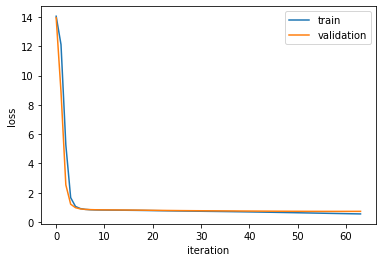

In [19]:
# plot training history
plt.plot(mf_opt.hist.history['loss'], label='train')
plt.plot(mf_opt.hist.history['val_loss'], label='validation')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend()
plt.show()

test prediction:

In [20]:
mf_opt.predict(test.user_id, test.item_id)

13/13 [==============================] - 0s 2ms/step


In [21]:
class my_metrics():
    
    THRESHOLD = 3

    def RMSE(y_true, y_pred, lower_bound=1, upper_bound=5):
        y_pred[y_pred<lower_bound] = lower_bound
        y_pred[y_pred>upper_bound] = upper_bound
        rel_preds = (y_true >= lower_bound) & (y_true <= upper_bound)
        return np.sqrt(((rel_preds * (y_true - y_pred))**2).sum() / rel_preds.sum())
    
    def MRR(df_true, df_pred, lower_bound=1, upper_bound=5, top_n=5, threshold_val=THRESHOLD):
        # please use MRR_for_user
        user_mrr = []
        for i in range(df_true.shape[0]):
            val = my_metrics.MRR_for_user(df_true[i,:], df_pred[i,:], lower_bound, upper_bound, top_n, threshold_val)
            if val is not None:
                user_mrr.append(val)
        return np.sum(user_mrr)/len(user_mrr)
    
    def MRR_for_user(user_true, user_pred, lower_bound, upper_bound, top_n, threshold_val):
        rel_preds = (user_true >= lower_bound) & (user_true <= upper_bound)
        if rel_preds.sum() == 0:
            return None
        screened_user_true = user_true[rel_preds]
        screened_user_pred = user_pred[rel_preds]

        top_n_pred_indicies = screened_user_pred.argsort()[::-1][:top_n]
        for i, (pred, actual) in enumerate(zip(screened_user_pred[top_n_pred_indicies], screened_user_true[top_n_pred_indicies])):
            if actual >= threshold_val:
                return 1.0/(i+1)
        
        return 0.0

    def NDCG(df_true, df_pred, lower_bound=1, upper_bound=5, top_n=5):
        # please use NDCG_for_user
        user_ndcg = []
        for i in range(df_true.shape[0]):
            user_ndcg.append(my_metrics.NDCG_for_user(df_true[i], df_pred[i], lower_bound, upper_bound, top_n))
        
        user_ndcg = [x for x in user_ndcg if math.isnan(x) == False]

        return np.sum(user_ndcg) / len(user_ndcg)
        
    def NDCG_for_user(user_true,user_pred,lower_bound=1,upper_bound=5,top_n=5):
        # please use DCG function
        rel_preds = (user_true >= lower_bound) & (user_true <= upper_bound)
        if rel_preds.astype(bool).sum() < top_n:
            return np.nan        
        screened_user_true = user_true[rel_preds]
        screened_user_pred = user_pred[rel_preds]
        top_n_pred_indicies = screened_user_pred.argsort()[::-1][:top_n]
        user_dcg = my_metrics.DCG(screened_user_true[top_n_pred_indicies])
        user_idcg = my_metrics.DCG(np.sort(screened_user_true[top_n_pred_indicies])[::-1])
        return user_dcg / user_idcg
    
    def DCG(rel):
        # please implement the DCG formula
        dcg = rel[0]
        for i in range(1, len(rel)):
            dcg += rel[i]/np.log2(i+2)

        return dcg
    
    def get_evaluation(df_true,df_pred):        
        return {'RMSE':my_metrics.RMSE(df_true,df_pred,),'MRR_5':my_metrics.MRR(df_true,df_pred,top_n=5),'MRR_10':my_metrics.MRR(df_true,df_pred,top_n=10),'NDCG_5':my_metrics.NDCG(df_true,df_pred,top_n=5),'NDCG_10':my_metrics.NDCG(df_true,df_pred,top_n=10)}

In [22]:
# mf_ml_rmse = my_metrics.RMSE(test.rating.values, mf_opt.predictions.reshape(-1))
# mf_ml_rmse

In [23]:
pred_df = test.copy()
pred_df.rating = mf_opt.predictions.reshape(-1)
pred_mat = df_to_mat(pred_df)
test_mat = df_to_mat(test)

In [24]:
mf_opt_eval = my_metrics.get_evaluation(test_mat, pred_mat)
mf_opt_eval

{'MRR_10': 0.9762339475153545,
 'MRR_5': 0.9762339475153545,
 'NDCG_10': 0.9671141808975139,
 'NDCG_5': 0.9715781786913942,
 'RMSE': 0.8606383510306934}

AutoRec

In [25]:
def dataPreprocessor(rating_df):
    train_df, test_df = train_test_split(rating_df, test_size=0.1, random_state=42)
    train_mat = np.zeros((rating_df.user_id.nunique(), rating_df.item_id.nunique()))
    for (user_id, item_id, rating) in zip(train_df.user_id, train_df.item_id, train_df.rating):
        train_mat[user_id, item_id] = rating

    # train_mat_avg = copy.copy(train_mat)
    # average = np.true_divide(train_mat_avg.sum(1), np.maximum((train_mat_avg!=0).sum(1), 1))
    # inds = np.where(train_mat_avg == 0)
    # train_mat_avg[inds] = np.take(average, inds[0])

    test_mat = np.zeros((rating_df.user_id.nunique(), rating_df.item_id.nunique()))
    for (user_id, item_id, rating) in zip(test_df.user_id, test_df.item_id, test_df.rating):
        test_mat[user_id, item_id] = rating

    # test_mat_avg = copy.copy(test_mat)
    # average = np.true_divide(test_mat_avg.sum(1), np.maximum((test_mat_avg!=0).sum(1), 1))
    # inds = np.where(test_mat_avg == 0)
    # test_mat_avg[inds] = np.take(average, inds[0])
    

    
    return train_mat, test_mat

In [26]:
class IAutoRec:
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
    mc = ModelCheckpoint('best_autorec_model.h5', monitor='val_loss', mode='min', save_best_only=True)
    # es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
    # mc = ModelCheckpoint('best_autorec_model.h5', monitor='loss', mode='min', save_best_only=True)

    def __init__(self, items_num, hidden_units=500, reg=0.0005, optimizer='Adam', loss='mean_squared_error', learning_rate=0.0001, first_activation='elu', last_activation='elu'):
        self.items_num = items_num
        self.hidden_units = hidden_units
        self.reg = reg
        self.optimizer = optimizer
        self.loss = loss
        self.learning_rate = learning_rate
        self.first_activation = first_activation
        self.last_activation = last_activation
        # input_layer = Input(shape=(rating_mat.shape[1],), name='item_rating')
        # dense = Dense(hidden_units, activation=first_activation, name='latent_dim', kernel_regularizer=regularizers.l2(reg))(input_layer)
        # output_layer = Dense(rating_mat.shape[1], activation=last_activation, name='item_pred_rating', kernel_regularizer=regularizers.l2(reg))(dense)
        # self.model = Model(input_layer, output_layer)

        # if optimizer=='Adam':
        #     # self.model.compile(optimizer=Adam(learning_rate=learning_rate), loss=loss)
        #     self.model.compile(optimizer=Adam(learning_rate=learning_rate), loss=self.masked_rmse)
        # else:
        #     raise Exception('Optimizer not implemented')

        # self.model.summary()

    def build_opt_model(self):
        input_layer = Input(shape=(self.items_num,), name='item_rating')
        dense = Dense(self.hidden_units, activation=self.first_activation, name='latent_dim', kernel_regularizer=regularizers.l2(self.reg))(input_layer)
        output_layer = Dense(self.items_num, activation=self.last_activation, name='item_pred_rating', kernel_regularizer=regularizers.l2(self.reg))(dense)
        self.model = Model(input_layer, output_layer)

        if self.optimizer=='Adam':
            # self.model.compile(optimizer=Adam(learning_rate=learning_rate), loss=loss)
            self.model.compile(optimizer=Adam(learning_rate=self.learning_rate), loss=IAutoRec.masked_rmse)
        else:
            raise Exception('Optimizer not implemented')

        self.model.summary()

    def model_builder(self, hp):
        input_layer = Input(shape=(self.items_num,), name='item_rating')
        hp_hidden_units = hp.Int('hidden_units', min_value=300, max_value=800, step=100)
        hp_reg = hp.Choice('reg', values=[0.01, 0.001, 0.0001])
        dense = Dense(hp_hidden_units, activation=self.first_activation, name='latent_dim', kernel_regularizer=regularizers.l2(hp_reg))(input_layer)
        output_layer = Dense(self.items_num, activation=self.last_activation, name='item_pred_rating', kernel_regularizer=regularizers.l2(hp_reg))(dense)
        self.model = Model(input_layer, output_layer)

        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        if self.optimizer=='Adam':
            # self.model.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss=self.loss)
            self.model.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss=IAutoRec.masked_rmse)
        else:
            raise Exception('Optimizer not implemented')

        self.model.summary()
        return self.model

    @staticmethod
    def masked_rmse(y_true, y_pred):
        mask = tf.cast(tf.not_equal(y_true, 0), dtype='float32') 
        e = y_true - y_pred
        se = e * e 
        se = se * mask
        mse = 1.0 * tf.reduce_sum(se) / tf.reduce_sum(mask)
        rmse = tf.math.sqrt(mse)
        return rmse

    def fit(self, rating_mat, rating_mat2,  batch_size=256, epochs=500, verbose=2):
        self.hist = self.model.fit(x=rating_mat,y=rating_mat2,
                                validation_split=0.1,
                                batch_size=batch_size, epochs=epochs, verbose=verbose, 
                                callbacks=[IAutoRec.es, IAutoRec.mc]) 
    
    def predict(self, rating_mat, batch_size=512, verbose=1):
        self.predictions = self.model.predict(rating_mat, 
                                 batch_size=batch_size, verbose=verbose)

In [27]:
train_mat, test_mat = dataPreprocessor(ratings_df)
autorec = IAutoRec(train_mat.shape[1])
tuner = kt.Hyperband(autorec.model_builder,
                     objective='val_loss',
                    #  objective='loss',
                     max_epochs=50,
                     factor=3,
                     directory='hyper_params',
                     project_name='autorec_ml')


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 item_rating (InputLayer)    [(None, 3706)]            0         
                                                                 
 latent_dim (Dense)          (None, 300)               1112100   
                                                                 
 item_pred_rating (Dense)    (None, 3706)              1115506   
                                                                 
Total params: 2,227,606
Trainable params: 2,227,606
Non-trainable params: 0
_________________________________________________________________


In [28]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
tuner.search(train_mat, train_mat,
             epochs=50, validation_split=0.2, callbacks=[stop_early], batch_size=512)
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 60 Complete [00h 00m 02s]
val_loss: 1.5102125406265259

Best val_loss So Far: 1.059554100036621
Total elapsed time: 00h 02m 16s
INFO:tensorflow:Oracle triggered exit


In [29]:
best_hps.get('hidden_units'), best_hps.get('reg'), best_hps.get('learning_rate')

(300, 0.0001, 0.001)

In [30]:
autorec_opt = IAutoRec(train_mat.shape[1],hidden_units=best_hps.get('hidden_units'), reg=best_hps.get('reg'), learning_rate=best_hps.get('learning_rate'))
autorec_opt.build_opt_model()
autorec_opt.fit(train_mat, train_mat)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 item_rating (InputLayer)    [(None, 3706)]            0         
                                                                 
 latent_dim (Dense)          (None, 300)               1112100   
                                                                 
 item_pred_rating (Dense)    (None, 3706)              1115506   
                                                                 
Total params: 2,227,606
Trainable params: 2,227,606
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
22/22 - 1s - loss: 2.2848 - val_loss: 1.4914 - 669ms/epoch - 30ms/step
Epoch 2/500
22/22 - 0s - loss: 1.2964 - val_loss: 1.1886 - 233ms/epoch - 11ms/step
Epoch 3/500
22/22 - 0s - loss: 1.1289 - val_loss: 1.1267 - 206ms/epoch - 9ms/step
Epoch 4/500
22/22 - 0s - loss: 1.0438 - val_loss: 1.0899 - 203ms/

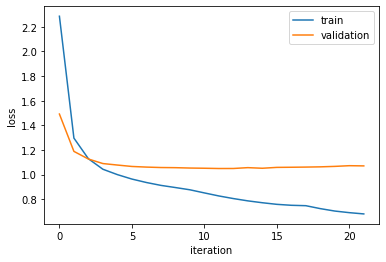

In [31]:
# plot training history
plt.plot(autorec_opt.hist.history['loss'], label='train')
plt.plot(autorec_opt.hist.history['val_loss'], label='validation')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend()

In [32]:
# autorec.predict(np.zeros(test_mat.shape))
autorec_opt.predict(test_mat)

12/12 [==============================] - 0s 4ms/step


In [33]:
autorec_opt_eval = my_metrics.get_evaluation(test_mat, autorec_opt.predictions)
autorec_opt_eval

{'MRR_10': 0.9845407593523171,
 'MRR_5': 0.9844919039642657,
 'NDCG_10': 0.9709291373980162,
 'NDCG_5': 0.9772104165700273,
 'RMSE': 1.3886617712117788}

In [34]:
class IAutoRecEnhanced:
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    mc = ModelCheckpoint('best_autorec_enhanced_model.h5', monitor='val_loss', mode='min', save_best_only=True)
    # es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
    # mc = ModelCheckpoint('best_autorec_enhanced_model.h5', monitor='loss', mode='min', save_best_only=True)

    def __init__(self, items_num, hidden_units=500, hidden_layer_factor=2, reg=0.0005, optimizer='Adam', loss='mean_squared_error', learning_rate=0.0001, first_activation='elu', last_activation='elu'):
        self.items_num = items_num
        self.hidden_units = hidden_units
        self.hidden_layer_factor = hidden_layer_factor
        self.reg = reg
        self.optimizer = optimizer
        self.loss = loss
        self.learning_rate = learning_rate
        self.first_activation = first_activation
        self.last_activation = last_activation

    def build_opt_model(self):
        input_layer = Input(shape=(self.items_num,), name='item_rating')
        hidden_layer_encoder = Dense(self.hidden_units*self.hidden_layer_factor, activation=self.first_activation, name='hidden_encoder', kernel_regularizer=regularizers.l2(self.reg))(input_layer)
        dense = Dense(self.hidden_units, activation=self.first_activation, name='latent_dim', kernel_regularizer=regularizers.l2(self.reg))(hidden_layer_encoder)
        hidden_layer_decoder = Dense(self.hidden_units*self.hidden_layer_factor, activation=self.last_activation, name='hidden_decoder', kernel_regularizer=regularizers.l2(self.reg))(dense)
        output_layer = Dense(self.items_num, activation=self.last_activation, name='item_pred_rating', kernel_regularizer=regularizers.l2(self.reg))(hidden_layer_decoder)
        self.model = Model(input_layer, output_layer)

        if self.optimizer=='Adam':
            # self.model.compile(optimizer=Adam(learning_rate=learning_rate), loss=loss)
            self.model.compile(optimizer=Adam(learning_rate=self.learning_rate), loss=IAutoRecEnhanced.masked_rmse)
        else:
            raise Exception('Optimizer not implemented')

        self.model.summary()

    def model_builder(self, hp):
        hp_hidden_units = hp.Int('hidden_units', min_value=300, max_value=800, step=100)
        hp_hidden_layer_factor = hp.Choice('hidden_layer_factor', values=[2, 3, 4])
        hp_reg = hp.Choice('reg', values=[0.01, 0.001, 0.0001])
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

        input_layer = Input(shape=(self.items_num,), name='item_rating')
        hidden_layer_encoder = Dense(hp_hidden_units*hp_hidden_layer_factor, activation=self.first_activation, name='hidden_encoder', kernel_regularizer=regularizers.l2(hp_reg))(input_layer)
        dense = Dense(hp_hidden_units, activation=self.first_activation, name='latent_dim', kernel_regularizer=regularizers.l2(hp_reg))(hidden_layer_encoder)
        hidden_layer_decoder = Dense(hp_hidden_units*hp_hidden_layer_factor, activation=self.last_activation, name='hidden_decoder', kernel_regularizer=regularizers.l2(hp_reg))(dense)
        output_layer = Dense(self.items_num, activation=self.last_activation, name='item_pred_rating', kernel_regularizer=regularizers.l2(hp_reg))(hidden_layer_decoder)
        self.model = Model(input_layer, output_layer)
        
        if self.optimizer=='Adam':
            # self.model.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss=self.loss)
            self.model.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss=IAutoRecEnhanced.masked_rmse)
        else:
            raise Exception('Optimizer not implemented')

        self.model.summary()
        return self.model

    @staticmethod
    def masked_rmse(y_true, y_pred):
        mask = tf.cast(tf.not_equal(y_true, 0), dtype='float32') 
        e = y_true - y_pred
        se = e * e 
        se = se * mask
        mse = 1.0 * tf.reduce_sum(se) / tf.reduce_sum(mask)
        rmse = tf.math.sqrt(mse)
        return rmse

    def fit(self, rating_mat,rating_mat2, batch_size=256, epochs=500, verbose=2):
        self.hist = self.model.fit(x=rating_mat,y=rating_mat2,
                                validation_split=0.1,
                                batch_size=batch_size, epochs=epochs, verbose=verbose, 
                                callbacks=[IAutoRecEnhanced.es, IAutoRecEnhanced.mc]) 
    
    def predict(self, rating_mat, batch_size=512, verbose=1):
        self.predictions = self.model.predict(rating_mat, 
                                 batch_size=batch_size, verbose=verbose)

In [35]:
autorec_enhanced = IAutoRecEnhanced(train_mat.shape[1])
tuner = kt.Hyperband(autorec_enhanced.model_builder,
                     objective='val_loss',
                    #  objective='loss',
                     max_epochs=50,
                     factor=3,
                     directory='hyper_params',
                     project_name='autorec_enhanced_ml')

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 item_rating (InputLayer)    [(None, 3706)]            0         
                                                                 
 hidden_encoder (Dense)      (None, 600)               2224200   
                                                                 
 latent_dim (Dense)          (None, 300)               180300    
                                                                 
 hidden_decoder (Dense)      (None, 600)               180600    
                                                                 
 item_pred_rating (Dense)    (None, 3706)              2227306   
                                                                 
Total params: 4,812,406
Trainable params: 4,812,406
Non-trainable params: 0
_________________________________________________________________


In [36]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
tuner.search(train_mat, train_mat,
             epochs=50, validation_split=0.2, callbacks=[stop_early], batch_size=512)
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 90 Complete [00h 00m 41s]
val_loss: 2.696207046508789

Best val_loss So Far: 1.1093991994857788
Total elapsed time: 00h 20m 50s
INFO:tensorflow:Oracle triggered exit


In [37]:
best_hps.get('hidden_units'), best_hps.get('hidden_layer_factor'), best_hps.get('reg'), best_hps.get('learning_rate')

(400, 3, 0.001, 0.001)

In [38]:
autorec_enhanced_opt = IAutoRecEnhanced(train_mat.shape[1],hidden_units=best_hps.get('hidden_units'), hidden_layer_factor=best_hps.get('hidden_layer_factor'), reg=best_hps.get('reg'), learning_rate=best_hps.get('learning_rate'))
autorec_enhanced_opt.build_opt_model()
autorec_enhanced_opt.fit(train_mat, train_mat)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 item_rating (InputLayer)    [(None, 3706)]            0         
                                                                 
 hidden_encoder (Dense)      (None, 1200)              4448400   
                                                                 
 latent_dim (Dense)          (None, 400)               480400    
                                                                 
 hidden_decoder (Dense)      (None, 1200)              481200    
                                                                 
 item_pred_rating (Dense)    (None, 3706)              4450906   
                                                                 
Total params: 9,860,906
Trainable params: 9,860,906
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
22/22 - 1s - loss: 4.9969 - val_loss:

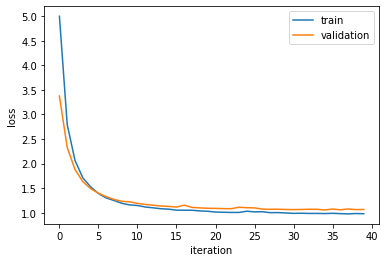

In [39]:
# plot training history
plt.plot(autorec_enhanced_opt.hist.history['loss'], label='train')
plt.plot(autorec_enhanced_opt.hist.history['val_loss'], label='validation')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend()

In [40]:
autorec_enhanced_opt.predict(test_mat)

12/12 [==============================] - 0s 5ms/step


In [41]:
autorec_enhanced_opt_eval = my_metrics.get_evaluation(test_mat, autorec_enhanced_opt.predictions)
autorec_enhanced_opt_eval

{'MRR_10': 0.9695102496610035,
 'MRR_5': 0.9694304857621441,
 'NDCG_10': 0.9570567523884,
 'NDCG_5': 0.9630679532240373,
 'RMSE': 1.109604537289434}

In [54]:
result_dict = {
    'mf': mf_opt_eval,
    'autorec': autorec_opt_eval,
    'autorec_enhanced': autorec_enhanced_opt_eval
               }
res_df = pd.DataFrame.from_dict(result_dict)
res_df

,mf,autorec,autorec_enhanced
RMSE,0.860638,1.388662,1.109605
MRR_5,0.976234,0.984492,0.969430
MRR_10,0.976234,0.984541,0.969510
NDCG_5,0.971578,0.977210,0.963068
NDCG_10,0.967114,0.970929,0.957057


Text(0.5, 1.0, 'movielens-1m models results')

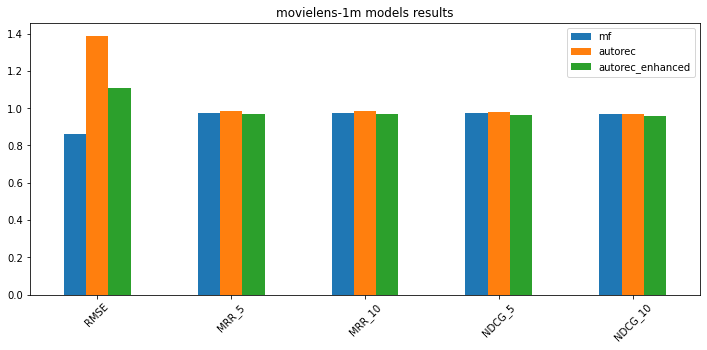

In [55]:
res_df.plot(kind='bar', figsize=(12,5), rot=45)
plt.title('movielens-1m models results')

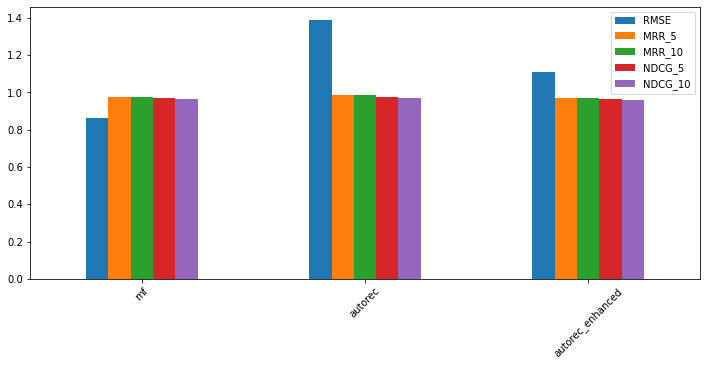

In [56]:
res_df.transpose().plot(kind='bar', figsize=(12,5), rot=45)

In [4]:
import requests
url = 'https://www.kaggle.com/netflix-inc/netflix-prize-data/data/download/archive.zip'
r = requests.get(url, allow_redirects=True)

In [13]:
zip_name = '/content/netflix_prize.zip'
open(zip_name, 'wb').write(r.content)

with zipfile.ZipFile(zip_name,"r") as zip_ref:
    zip_ref.extractall()

BadZipFile: ignored